In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp
from scipy.stats import binned_statistic
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# from MAF. Should eventually go to sims_utils
def calcSeason(ra, time):
    """Calculate the 'season' in the survey for a series of ra/dec/time values of an observation.
    Based only on the RA of the point on the sky, it calculates the 'season' based on when this
    point would be overhead .. the season is considered +/- 0.5 years around this time.

    Parameters
    ----------
    ra : float
        The RA (in degrees) of the point on the sky
    time : np.ndarray
        The times of the observations, in MJD

    Returns
    -------
    np.ndarray
        The season values
    """
    # Reference RA and equinox to anchor ra/season reference - RA = 0 is overhead at autumnal equinox
    # autumn equinox 2014 happened on september 23 --> equinox MJD
    Equinox = 2456923.5 - 2400000.5
    # convert ra into 'days'
    dayRA = ra / 360 * 365.25
    firstSeasonBegan = Equinox + dayRA - 0.5 * 365.25
    seasons = (time - firstSeasonBegan) / 365.25
    # Set first season to 0
    seasons = seasons - np.floor(np.min(seasons))
    return seasons

In [3]:
ddf_data = np.load('ddf_grid.npz')
ddf_grid = ddf_data['ddf_grid'].copy()

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >=0) & (ack < 0))] += 1
night = np.cumsum(night)

In [4]:
ddf_grid

array([(59853.5       ,  0.35789797, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.51041667,  0.41360456, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.52083333,  0.46894875, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       ...,
       (63505.96874915, -0.12942338, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.97916582, -0.18569237, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.98958248, -0.24112162, 1.90646443, 20.87839022, 23.56106875, -9.35888477, nan, nan, -8.85712875, nan, nan, -1.36598529, nan, nan, -1.4

In [5]:
# check what the timestep is
24*60*(ddf_grid['mjd'][1] - ddf_grid['mjd'][0])

14.99999999650754

In [6]:
season = calcSeason(9.45, ddf_grid['mjd'])

In [7]:
season % 1 # Can set things to be 0 when out of season, and 1 in season. Then do a cumsum, normalize, maybe round.

array([0.49702173, 0.49705025, 0.49707877, ..., 0.49693617, 0.49696469,
       0.49699321])

In [8]:
m = gp.Model("try_sched")

Academic license - for non-commercial use only - expires 2021-12-19
Using license file /Users/yoachim/Dropbox/Apps/Gurobi/gurobi.lic


In [9]:
ngrid = ddf_grid['mjd'].size
sun_limit = np.radians(-18.)
airmass_limit = 2.1  
sky_limit = 22. #20. #21.5 #22.
zeropoint = 25.0  # mags
sequence_limit = 400 #230
pause_time = 13/24.  # days
RA = 9.45  # RA of the DDF
delta_t = ddf_grid['mjd'][1] - ddf_grid['mjd'][0]

# Let's try scheduling just one for now
schedule = m.addMVar(ngrid, vtype=GRB.BINARY, name="pointing_1")

# set a sun mask
sun_mask = np.zeros(ngrid, dtype=bool)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 1

airmass_mask = np.zeros(ngrid, dtype=bool)
airmass_mask[np.where(ddf_grid['DD:ELAISS1_airmass'] >= airmass_limit)] = 1

sky_mask = np.zeros(ngrid, dtype=bool)
sky_mask[np.where(ddf_grid['DD:ELAISS1_sky_g'] <= sky_limit)] = 1
sky_mask[np.where(np.isnan(ddf_grid['DD:ELAISS1_sky_g']) == True)] = 1

# Let's add the constraints
m.addConstr(schedule @ sun_mask == 0)
m.addConstr(schedule @ airmass_mask == 0)
m.addConstr(schedule @ sky_mask == 0)

# limit the total number of ddf sequences
# HA! Need to set an exact number I think. Or maybe a range.
m.addConstr(schedule.sum() == sequence_limit)


# prevent a repeat sequence in a night
unights, indx = np.unique(night, return_index=True)
night_mjd = ddf_grid['mjd'][indx]
# The season of each night
night_season = calcSeason(RA, night_mjd)
sched_night = m.addMVar(unights.size, vtype=GRB.INTEGER)
for i,n in enumerate(unights):
    in_night = np.where(night == n)[0]
    m.addConstr(schedule[in_night]@schedule[in_night] <= 1)
    m.addConstr(sched_night[i] == schedule[in_night].sum())

In [10]:
blank = np.ones(ngrid, dtype=int)
blank[np.where(sky_mask == 1)] = 0
blank[np.where(airmass_mask == 1)] = 0
blank[np.where(sun_mask == 1)] = 0
bins = np.arange(np.min(night)-0.5, np.max(night)+1.5)
slots_per_night, _be, _bn = binned_statistic(night, blank, statistic=np.sum, bins=bins)

# Let's modify so it's equal weight any place there are more than N slots in a night
slot_limit = 1
slots_per_night[np.where(slots_per_night < slot_limit)] = 0
slots_per_night[np.where(slots_per_night >= slot_limit)] = 1


# ok, let's forbid 4 day gaps:
# that was fun, splits the median peak at 4 into 3 and 5.
#m.addConstr(sched_night[:-4]@sched_night[4:] == 0)


In [11]:
#slots_per_night
#cumulative_desired = np.cumsum(slots_per_night)
#cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit
# what happens if I put a floor on this to make my desired one discrete?
# Makes it go blazing fast agian, that's for sure!
# cumulative_desired = np.round(cumulative_desired)

raw_obs = np.ones(unights.size)
# take out the ones that are out of season
season_mod = night_season % 1
# 7.2 month observing season if season_frac = 0.2
season_frac = 0.2
out_season = np.where((season_mod < season_frac) | (season_mod > (1.-season_frac)))
raw_obs[out_season] = 0
cumulative_desired = np.cumsum(raw_obs)
cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit

# Makes it go blazing fast agian, that's for sure!
cumulative_desired = np.round(cumulative_desired)



In [12]:
# Let's compute the potential energy of the distribution and minimize that
position = np.arange(unights.size)
# Here's an objective that works
#obj = sched_night[:-1]@sched_night[1:] + sched_night[:-2]@sched_night[2:]*0.5 + sched_night[:-3]@sched_night[3:]*(1./3)
obj = sched_night[:-1]@sched_night[1:]
for i in range(2,5):
    obj += sched_night[:-i]@sched_night[i:]*(1./i)


# Compute t_eff, something we want to maximize
t_eff = 10.**(.08*(ddf_grid['DD:ELAISS1_m5_g']-zeropoint))
t_eff[np.where(np.isnan(t_eff) == True)] = 0
t_eff[np.where(np.isinf(t_eff) == True)] = 0


In [13]:
RA

9.45

In [14]:

# Cumulative number of scheduled events (by night, to avoid huge loop)
cumulative_sched = m.addMVar(unights.size, vtype=GRB.INTEGER)
cumulative_diff = m.addMVar(unights.size, vtype=GRB.INTEGER, lb=-sequence_limit, ub=sequence_limit)

cumulative_dmax = m.addMVar(unights.size, vtype=GRB.INTEGER)


m.addConstr(cumulative_sched[0] == sched_night[0])

#linear_cumulative = np.arange(unights.size)
#linear_cumulative = linear_cumulative/np.max(linear_cumulative) * sequence_limit
#m.addConstr(cumulative_diff[0] == cumulative_sched[0] - linear_cumulative[0])
m.addConstr(cumulative_diff[0] == cumulative_sched[0] - cumulative_desired[0])


for i in np.arange(1,unights.size):
    m.addConstr(cumulative_sched[i] == cumulative_sched[i-1]+sched_night[i])
    m.addConstr(cumulative_diff[i] == cumulative_sched[i] - cumulative_desired[i])
    

In [15]:
cumulative_diff

<(3653,) matrix variable>

(21.0, 23.0)

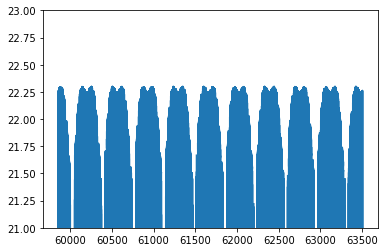

In [16]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])

In [17]:
# maximize the t_eff
#m.setObjective(t_eff@schedule, GRB.MAXIMIZE)
# minimize the potential energy
#m.setObjective(obj, GRB.MINIMIZE)
# Try to match a CDF
m.setObjective(cumulative_diff@cumulative_diff, GRB.MINIMIZE)

In [18]:
m.Params.TimeLimit = 200
m.optimize()

Changed value of parameter TimeLimit to 200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10963 rows, 365252 columns and 1302550 nonzeros
Model fingerprint: 0xa40e4683
Model has 3653 quadratic objective terms
Model has 3653 quadratic constraints
Variable types: 0 continuous, 365252 integer (350640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+00, 4e+02]
  QRHS range       [1e+00, 1e+00]
Presolve removed 7310 rows and 359950 columns
Presolve time: 0.65s
Presolved: 3653 rows, 5302 columns, 10603 nonzeros
Presolved model has 3652 quadratic objective terms
Variable types: 0 continuous, 5302 integer (1650 binary)

Root relaxation: objective 7.558561e+02, 7335 it

In [19]:
result_array = schedule.X

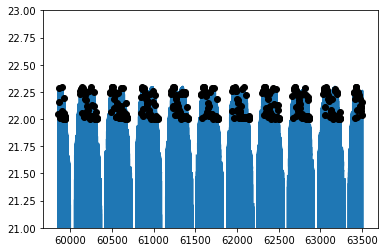

In [20]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')

(60000.0, 60500.0)

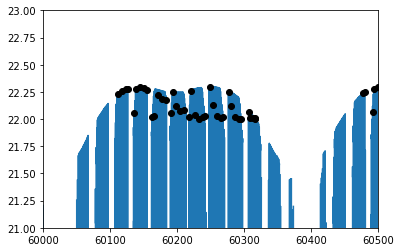

In [21]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60000, 60500)

In [22]:
np.where( (ddf_grid['mjd'][sched] > 60300) & (ddf_grid['mjd'][sched] < 60400))

(array([55, 56, 57, 58, 59]),)

In [23]:

#ack = ddf_grid['DD:ELAISS1_airmass'][np.where((ddf_grid['mjd'] > 60300) & (ddf_grid['mjd'] < 60400))]
#ack[np.where((ack > 1) & (ack < 2.5))]

(60050.0, 60200.0)

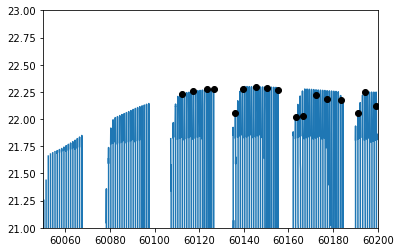

In [24]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60050, 60200)

(60120.0, 60160.0)

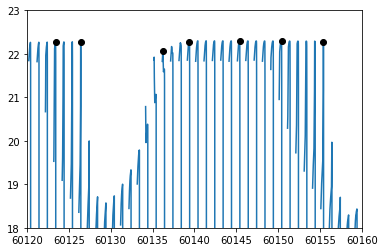

In [25]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([18,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60120, 60160)

In [26]:
# can try to also optimize uniformity! Could use the KS statistic. 

# Good answer on how to do a cumulative sum here:  https://stackoverflow.com/questions/55840816/gurobi-prefix-sum-optimization

In [27]:
#m.setObjective(gp.max_(cumulative_diff), GRB.MINIMIZE)

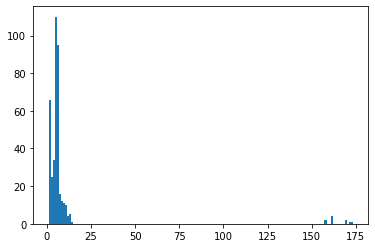

In [28]:
ack = plt.hist(np.diff(ddf_grid['mjd'][sched]), bins=150)

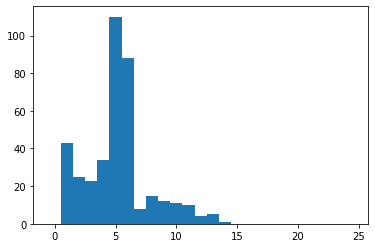

In [29]:
ack = plt.hist(np.diff(ddf_grid['mjd'][sched]), bins=np.arange(-0.5,25.5, 1))

In [30]:
np.median(np.diff(ddf_grid['mjd'][sched]))

4.999999998835847

In [31]:
cumulative_diff.X.min()

-1.0

In [32]:
cumulative_diff.X.max()

4.0

In [33]:
cumulative_diff.X

array([0., 0., 0., ..., 0., 0., 0.])

Text(0, 0.5, 'Cumulative nuumber of events')

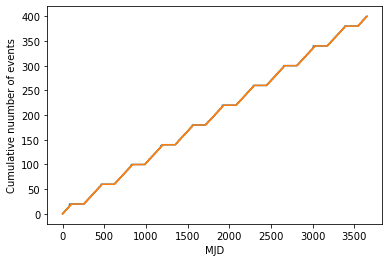

In [34]:
plt.plot(cumulative_sched.X)
plt.plot(cumulative_desired)
plt.xlabel('MJD')
plt.ylabel('Cumulative nuumber of events')

Text(0, 0.5, 'Cumulative number of events')

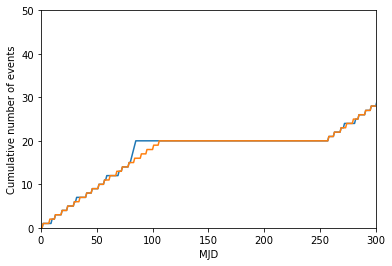

In [35]:
plt.plot(cumulative_sched.X)
plt.plot(cumulative_desired)
plt.xlim([0,300])
plt.ylim(0,50)
plt.xlabel('MJD')
plt.ylabel('Cumulative number of events')

Text(0, 0.5, 'Cumulative number of events desired-actual')

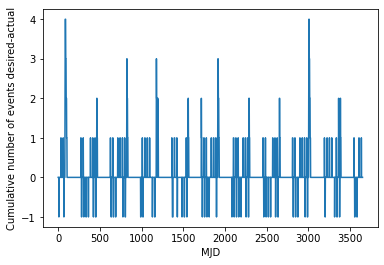

In [36]:
plt.plot(cumulative_diff.X)
plt.xlabel('MJD')
plt.ylabel('Cumulative number of events desired-actual')

# I can have an objective function that works for effective exposure time. I have an objective function that maximizes potential energy of the distribution. I can't have too many terms in that one though, or it slows down. Maybe I need an objective that tries to make the distribution match a uniform CDF? Or I could bin down into blocks of 10 nights, and then do the potential between those. Kind of a tree-sph thing.

# Next steps

* try running with the t_eff max at the same time
* try scheduling 2 DDFs at the same time
* try different possible CDFs (rolling and acourdian) 
* Need to make the CDF not go flat over lunar breaks to force it to cover the gaps better--looks good!